In [1]:
import torch
from torchvision import transforms

from yacs.config import CfgNode
from PIL import Image
import os
import matplotlib.pyplot as plt

from models import SPDCN

device = ['cpu', 'cuda:0'][1]

In [2]:
config = CfgNode(dict(
    FACTOR = 128,
    resume = '../../spdcn.pth', # the path to checkpoints
    norm_mean = [0.56347245, 0.50660025, 0.45908741],
    norm_std = [0.28393339, 0.2804536 , 0.30424776]
))

img_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = config.norm_mean, std = config.norm_std)
])

In [4]:
model = SPDCN(config)

checkpoint = torch.load(config.resume, map_location='cpu')
msg = model.load_state_dict(checkpoint, strict=False)

model = model.to(device)

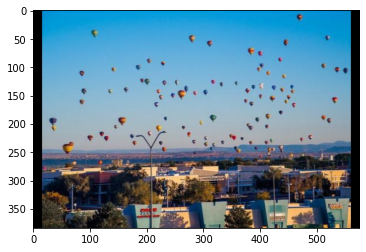

In [5]:
impath = os.path.join("md-files", "5.jpg")

img_pil = Image.open(impath)
plt.imshow(img_pil)

image = img_trans(img_pil)[None, ...].to(device)

In [5]:
# three boxes
# each is organized as [[w1, h1], [w2, h2]]
box = [
    [[532,  99], [540, 112]],
    [[329, 126], [334, 136]],
    [[255, 142], [268, 159]]
]

box = torch.cat((
    torch.zeros((len(box), 1)),
    torch.tensor(box).view(-1, 4),
), dim=1).to(device)

In [6]:
model.eval()
with torch.inference_mode():
    denmap = model(image, box)
    denmap = denmap / config.FACTOR

/home/grads/wlin38/anaconda3/envs/cu11/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The count of "md-files/5.jpg" is 78.13


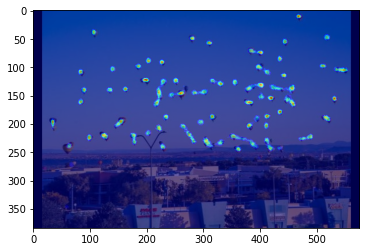

In [7]:
dencpu = denmap.squeeze().cpu()

plt.imshow(img_pil)
plt.imshow(dencpu, alpha=0.6, cmap='jet')

print(f"The count of \"{impath}\" is {denmap.sum().item():.2f}")